In [1]:

%tensorflow_version 1.x

TensorFlow 1.x selected.


In [1]:
# библиотека с популярными сервисами распознавания речи
!pip install SpeechRecognition 

     |████████████████████████████████| 32.8MB 177kB/s 


In [2]:
!pip install jiwer 

     |████████████████████████████████| 51kB 2.6MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp36-cp36m-linux_x86_64.whl size=148904 sha256=b888e87fd2a0a2888ac0bbde760350447e9ea1d64548e41df0d1bb44bf83f062
  Stored in directory: /root/.cache/pip/wheels/b3/26/73/4b48503bac73f01cf18e52cd250947049a7f339e940c5df8fc
Successfully built python-Levenshtein


In [5]:
!pip install ffmpeg-python


In [6]:
import speech_recognition as sR
from jiwer import wer # модуль метрики качества в распознавании речи
import numpy as np # библиотека для работы с массивами данных
from matplotlib import pyplot as plt # интерфейс для построения графиков простых функций
from IPython.display import HTML, Audio # загружаем модуль чтобы обратиться к HTML для записи аудио с микрофона в ноутбуке
from google.colab import files # модуль для загрузки файлов
from google.colab.output import eval_js
from base64 import b64decode # модуль для кодировки/раскодировки аудиозаписи(64-разрядный код)
from scipy.io.wavfile import read as wav_read # для чтения WAV формата
import io
import scipy # воспользуемся модулями библиотеки для работы со звуковой дорожкой
import librosa # для параметризации аудио
import os # модуль для работы с операционной системой(воспользуемся методами работы с каталогами)
from sklearn.model_selection import train_test_split # модуль для разбивки данных на обучающую и тестовую выборки
from keras.utils import to_categorical # загружаем утилиты кераса для one hot кодировки
from tqdm import tqdm # быстрый, удобный progress bar для Python
from keras.optimizers import Adam, RMSprop, Adadelta # загружаем алгоритмы обучения/оптимизации
from keras.models import Sequential # последовательная модель нейросети кераса
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization # загружаем необходимые слои для нейросети
import IPython.display as ipd #Для проигрывания аудио
import ffmpeg # кроссплатформенная open-source библиотека для обработки видео- и аудиофайлов

In [7]:
# подключаем гугл драйв диск для загрузки файлов
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
AUDIO_HTML = """
<script>  // создаем тег <script>, сообщающий браузеру о том, что внутри находится исполняемый код JavaScript
var my_div = document.createElement("DIV");  // создаем новый элемент DIV(тег-контейнер для логического выделения блока документа)
var my_p = document.createElement("P");  // создаем новый элемент P(параграф для логической группировки текста)
var my_btn = document.createElement("BUTTON");  // создаем новый элемент(кнопку) BUTTON
var t = document.createTextNode("Press to start recording");  // создаем текстовое содержимое для кнопки

my_btn.appendChild(t);  // добавляем текстовое содержимое элементу BUTTON
my_div.appendChild(my_btn);  // кнопку с текстом BUTTON добавляем в блок DIV
document.body.appendChild(my_div);  // добавляем наш блок в элемент <body>("тело", для хранения содержимого веб-страницы)

var base64data = 0;  // будем использовать для аудиоданных метод кодирования информации в 64-разрядный код
var reader;  // создаем переменную для чтения файла
var recorder, gumStream; // объявляем переменные для записи данных/потока
var recordButton = my_btn; //  создаем переменную для кнопки записи аудио с микрофона

var handleSuccess = function(stream) {  // объявляем функцию для работы с потоками данных
  gumStream = stream;  // создаем переменную для потока
  var options = {
    mimeType : 'audio/webm;codecs=opus' // в опциях задаем медиа тип с аудиоформатом и кодеками
  };            
  recorder = new MediaRecorder(stream); // создаем новый объект MediaRecorder, получающий медиапоток для записи.
  // MediaRecorder - интерфейс MediaStream Recording API представляющий функциональность для простой записи медиа. Создается..
  // ..с использованием MediaRecorder() конструктора.
  recorder.ondataavailable = function(e) {  // вызываем обработчик dataavailable события, запускаемое по окончанию записи          
    var url = URL.createObjectURL(e.data); // этим методом создаем DOMString(UTF-16 String), содержащий URL с указанием на объект e.data
    var preview = document.createElement('audio'); // создаем элемент-тег аудио
    preview.controls = true; // активизируем элементы управления
    preview.src = url; // берем в кач-ве исходных данных файл, содержащийся в записанной ранее URL
    document.body.appendChild(preview); //добавляем элемент аудио в <body>("тело", для хранения содержимого веб-страницы)

    reader = new FileReader();  // создаем объект класса FileReader для чтения разных источников данных
    reader.readAsDataURL(e.data);  // читаем содержимое указанного файла
    reader.onloadend = function() {  // обработчик события, запускаемого после передачи данных
      base64data = reader.result; // записываем прочитанное содержимое в base64data
    }
  };
  recorder.start();  // начало записи медиа
  };

recordButton.innerText = "Recording... press to stop"; // такой текст будет на кнопке BUTTON во время записи аудио

// запрос разрешения пользователя на доступ к устройству захвата аудио(микрофон), указываем True
navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {  // функция опишет действия по завершению записи (после клика мышкой по кнопке "Recording... press to stop")
  if (recorder && recorder.state == "recording") {  // если рекордер находится в процессе записи 
      recorder.stop();  // рекордер прерывается
      gumStream.getAudioTracks()[0].stop();  // отключается запись и доступ к микрофону
      recordButton.innerText = "Saving the recording... pls wait!" // эта надпись(сохранение записи) отобразится на кнопке BUTTON 
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {  // создаем функцию с задержкой вызова
  return new Promise(resolve => setTimeout(resolve, ms));  
  // new Promise - конструкция для отложенных вычислений
  // setTimeout позволяет вызвать функцию один раз через определённый интервал времени
}

var data = new Promise(resolve=>{
recordButton.onclick = ()=>{  // при нажатии левой кнопкой мыши на кнопку "Recording... press to stop"
toggleRecording()  // вызывается функция завершения аудиозаписи

sleep(2000).then(() => {  // и после задержки 2000мс(2 сек)
  resolve(base64data.toString())  // полученные данные из формата base64 преобразовываем в строку

});

}
});
      
</script>
"""

def get_audio(): # объявляем функцию извлечения аудио, записанного через микрофон в ноутбуке
  display(HTML(AUDIO_HTML)) # c помощью модулей библиотеки IPython отображаем результат выполнения записанного выше скрипта AUDIO_HTML
  data = eval_js("data") # данные на выходе запишем в data как результат выполнения javascript кода
  # data сейчас в таком виде: 'data:audio/webm;codecs=opus;base64,GkXfo59ChoEBQveBAULygQRC84EIQoKEd2VibUKHgQRChYE...mpZpkq1'
  binary = b64decode(data.split(',')[1]) #отсекаем информацию "data:audio/webm;codecs=opus;base64", оставляем только данные и декодируем
  # b'\x1aE\xdf\xa3\x9fB\x86\x81\x01B\xf7\x81\x01B\xf2

  process = (ffmpeg
    .input('pipe:0') # поток стандартного ввода
    .output('pipe:1', format='wav') # стандартного вывода в формате wav 
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)) # асинхронное выполнение командной строки FFmpeg
  # binary преобразовываем в wav, с типичным для медиафайлов форматом RIFF(ResourceInterchangeFileFormat - формат файла для обмена ресурсами)
  output, err = process.communicate(input=binary)
  # output - b'RIFF\xff\xff\xff\xffWAVEfmt \x10\x00\x00\x00\x01\x00\x01\x00\x80\xbb\x00\x00\...\x01\x00\x01\x00\x01\x0\xff'
  # err - b"ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers\n...headers:0kB muxing overhead: 0.046695%\n"


  # Cодержимое файла группируется из отдельных секций (chunks) - формат выборок аудиоданных. Секция имеет свой заголовок и данные секции.
  # Размер заголовка секции RIFF - 8 байт, их ниже уберём из определения размера секции RIFF
  riff_chunk_size = len(output) - 8 
  # Разбиваем размер секции на четыре байта, которые запишем далее в b.
  q = riff_chunk_size
  b = [] 
  for i in range(4):
      q, r = divmod(q, 256) # возьмем размер секции и вернем частное и остаток от деления на 256, и так 4 раза 
      b.append(r) # каждый из остатков добавим в список

  # Меняем байты c 4го по 7й вкл-но('\xff\xff\xff\xff') в output на b (типа '\xc62\x02\x00')
  riff = output[:4] + bytes(b) + output[8:]

  # класс io.BytesIO позволит работать с последовательностью байтов как с файловым объектом, а далее прочитаем как wav файл
  sr, audio = wav_read(io.BytesIO(riff)) # извлечём частоту дискретизации и полученный сигнал

  return audio, sr # функция вернет полученный сигнал и частоту дискретизации

In [25]:
audio, sr = get_audio() # запишем аудио через микрофон

In [26]:
# Сохраним запись в формате wav
scipy.io.wavfile.write('recording1.wav', sr, audio)

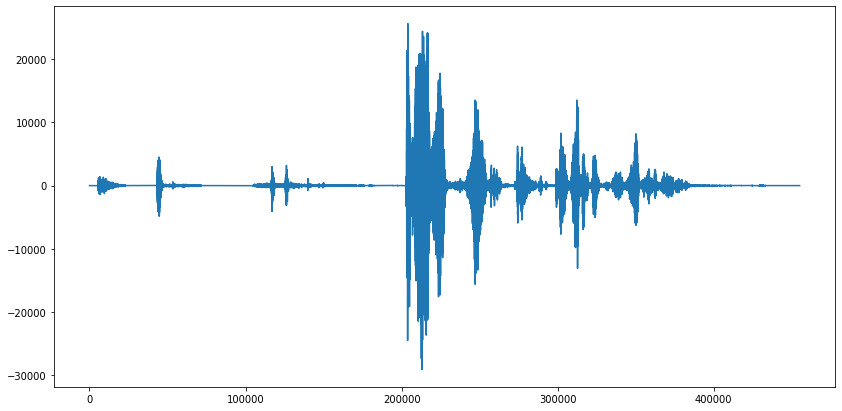

In [27]:
# Выведем график на экран
plt.figure(figsize=(14,7))
plt.plot(audio)
plt.show()

In [28]:
import IPython.display as ipd # Воспроизведение звуковыйх файлов

In [29]:
ipd.Audio(data=audio[30000:150000], rate = sr)

In [30]:
# Зададим функцию распознавания аудио с помощью speech_recognition
##########################
def recognizeAudio(filename, duration=None):
  AUDIO_FILE = os.path.join(filename) # задаем путь к аудиофайлу
  r = sR.Recognizer() # создаем объект класса Recognizer
  with sR.AudioFile(AUDIO_FILE) as source:
    audio = r.record(source, duration=duration) # считываем аудиофайл

  return r.recognize_google(audio, language='ru') # запускаем распознавание

In [31]:
# Проверим результат работы
original = 'раз-два-три проверка студийной аппаратуры'
res = recognizeAudio('recording1.wav', duration=None)

print('Оригинал:               ', original)
print('Результат распознавания:', res)
print('WER:', wer(original.lower(), res.lower()))

Оригинал:                раз-два-три проверка студийной аппаратуры
Результат распознавания: проверка студийной аппаратуры
WER: 0.25
